<a href="https://colab.research.google.com/github/KARTH33K/Deep-Learning/blob/main/Dense_Neural_Network_New_England_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New England Energy Consumption Prediction

Below are hourly observations of weather vs. energy (electricity) consumption in New England.


# Model Approach

This notebook is structed as per below model building approach:

**Prep the data:**
* Read the energy/weather data: https://drive.google.com/file/d/1ylQJKeCyMStvvMzRGDo8nR1TI8_3xGgP/view?usp=sharing
* Select columns for modeling:
  * Checked for missing values and inspected data types
  * The target variable is last column df['MWh']
  * We can use as many columns for X, but I used df['tmpf'] through `df['sknt']` along with the df['HE'] (which is the hour of the day).
    * A data dictionary for the weather data can be found at the bottom of this website: https://mesonet.agron.iastate.edu/request/download.phtml
  
* Used an 80/20 train/val split
* Applied min/max scalar to X_train and applied the same on X_test
<BR>

**Build, compile and fit the model**
* We can use as many or as few layers as we would like, with as many or as few hidden units as we would like. I tried multiple layers and finally chose 3 layers. (other layers are commented out)
* I used  dropout and early stopping.
  * Some hints and a examples of using dropout - values between 0.2 and 0.5 work well. https://machinelearningknowledge.ai/keras-dropout-layer-explained-for-beginners/<BR><BR>


**Evaluate the model:**
* Made a learning curve for train and validation loss
* Created a scatterplot of actual vs. predicted for each partition
* Calculated MAE, RMSE and R2 for each partition.
* Couple of observations, insights and experience with this model building

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov  7 15:41:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    46W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Libraries

In [ ]:
import pandas as pd # for data wrangling
import numpy as np # for array calculations, some math functions
from matplotlib import pyplot as plt #for plotting
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [ ]:
import seaborn as sns

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(
    3001336
)

## Read and prepare data
Read data, split data, minmax normalization

### Import data, head

In [ ]:
# read from shareable link
#https://drive.google.com/file/d/1ylQJKeCyMStvvMzRGDo8nR1TI8_3xGgP/view?usp=sharing
!gdown 1ylQJKeCyMStvvMzRGDo8nR1TI8_3xGgP
df = pd.read_csv('cleanweather_energy.csv')

Downloading...
From: https://drive.google.com/uc?id=1ylQJKeCyMStvvMzRGDo8nR1TI8_3xGgP
To: /content/cleanweather_energy.csv
100% 25.4k/25.4k [00:00<00:00, 36.6MB/s]


In [ ]:
df.head()

,valid,station,valid.1,lon,lat,tmpf,dwpf,relh,drct,sknt,...,peak_wind_gust,peak_wind_drct,peak_wind_time,feel,metar,snowdepth,H,Date,HE,MWh
0,2020-08-25 00:00:00,BDL,2020-08-25 00:55:00,-72.6825,41.9381,73.9,69.1,84.97,240.0,3.0,...,M,M,M,M,KBDL 250055Z AUTO 24002KT 10SM CLR 23/21 A2990...,M,D,2020-08-25 00:00:00,0,14986.78
1,2020-08-25 01:00:00,BDL,2020-08-25 01:55:00,-72.6825,41.9381,73.9,70.0,87.63,260.0,4.0,...,M,M,M,M,KBDL 250155Z AUTO 21002KT 10SM CLR 23/21 A2988...,M,D,2020-08-25 01:00:00,1,14433.29
2,2020-08-25 02:00:00,BDL,2020-08-25 02:55:00,-72.6825,41.9381,72.0,70.0,93.43,230.0,5.0,...,M,M,M,M,KBDL 250255Z AUTO 19004KT 10SM CLR 23/21 A2987...,M,D,2020-08-25 02:00:00,2,14152.24
3,2020-08-25 03:00:00,BDL,2020-08-25 03:55:00,-72.6825,41.9381,73.0,70.0,90.32,230.0,5.0,...,M,M,M,M,KBDL 250355Z AUTO 23002KT 10SM CLR 22/21 A2987...,M,D,2020-08-25 03:00:00,3,13846.08
4,2020-08-25 04:00:00,BDL,2020-08-25 04:55:00,-72.6825,41.9381,72.0,70.0,93.43,190.0,5.0,...,M,M,M,M,KBDL 250455Z AUTO 00000KT 10SM CLR 22/21 A2987...,M,D,2020-08-25 04:00:00,4,13872.55


### Shape, column names, data types, missing values

In [ ]:
df.shape

(96, 37)

Data has 96 rows and 37 columns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   valid              96 non-null     object 
 1   station            96 non-null     object 
 2   valid.1            96 non-null     object 
 3   lon                96 non-null     float64
 4   lat                96 non-null     float64
 5   tmpf               96 non-null     float64
 6   dwpf               96 non-null     float64
 7   relh               96 non-null     float64
 8   drct               96 non-null     float64
 9   sknt               96 non-null     float64
 10  p01i               96 non-null     float64
 11  alti               96 non-null     float64
 12  mslp               96 non-null     float64
 13  vsby               96 non-null     float64
 14  gust               22 non-null     float64
 15  skyc1              96 non-null     object 
 16  skyc2              96 non-nu

The required columns for modelling : tmpf, dwpf, relh, drct, sknt, HE
are all in intended data type format 

In [ ]:
df.isnull().sum()

valid                 0
station               0
valid.1               0
lon                   0
lat                   0
tmpf                  0
dwpf                  0
relh                  0
drct                  0
sknt                  0
p01i                  0
alti                  0
mslp                  0
vsby                  0
gust                 74
skyc1                 0
skyc2                 0
skyc3                 0
skyc4                 0
skyl1                 0
skyl2                 0
skyl3                 0
skyl4                 0
wxcodes               0
ice_accretion_1hr     0
ice_accretion_3hr     0
ice_accretion_6hr     0
peak_wind_gust        0
peak_wind_drct        0
peak_wind_time        0
feel                  0
metar                 0
snowdepth             0
H                     0
Date                  0
HE                    0
MWh                   0
dtype: int64

No missing data in input columns tmpf, dwpf, relh, drct, sknt, HE

### Dummy variables for HE
HE is the hour of the day. The values represent hour labels from 0-23 and considering them as numeric values can skew results.   

In [ ]:
# Creating dummy variables from one column:
df = pd.get_dummies(df, columns=['HE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 60 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   valid              96 non-null     object 
 1   station            96 non-null     object 
 2   valid.1            96 non-null     object 
 3   lon                96 non-null     float64
 4   lat                96 non-null     float64
 5   tmpf               96 non-null     float64
 6   dwpf               96 non-null     float64
 7   relh               96 non-null     float64
 8   drct               96 non-null     float64
 9   sknt               96 non-null     float64
 10  p01i               96 non-null     float64
 11  alti               96 non-null     float64
 12  mslp               96 non-null     float64
 13  vsby               96 non-null     float64
 14  gust               22 non-null     float64
 15  skyc1              96 non-null     object 
 16  skyc2              96 non-nu

In [ ]:
df.iloc[1:5, 35:60] #to observe the proper creation of dummy variables

,MWh,HE_0,HE_1,HE_2,HE_3,HE_4,HE_5,HE_6,HE_7,HE_8,...,HE_14,HE_15,HE_16,HE_17,HE_18,HE_19,HE_20,HE_21,HE_22,HE_23
1,14433.29,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14152.24,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13846.08,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13872.55,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Prepare data for model
Assigning target variable, input variables, test partition and scaling

### Assign target variable df['MWh'] for y

In [ ]:
Y = df['MWh']

### Assign input matrix X

In [ ]:
X = df[['tmpf','dwpf','relh','drct','sknt','HE_0','HE_1','HE_2','HE_3','HE_4','HE_5','HE_6','HE_7','HE_8','HE_9','HE_10','HE_11','HE_12','HE_13','HE_14','HE_15','HE_16','HE_17','HE_18','HE_19','HE_20','HE_21','HE_22','HE_23']]

In [ ]:
X.shape

(96, 29)

In [ ]:
# convert to numpy array
X = np.array(X)
Y = np.array(Y)

### Split into X_train, X_test, y_train, y_test 80/20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 3001336)

### Scaling the data using MinMaxScaler()

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Building the model

Strategy: Halfing the number of nodes by half through the hidden layers

In [ ]:
model = Sequential()
model.add(Dense(30, input_shape=(X_train.shape[1],), activation='relu')) # first hidden layer
model.add(Dropout(0.2))
# model.add(Dense(15, activation='relu')) #second hidden layer
# model.add(Dropout(0.2))
model.add(Dense(7, activation='relu')) #Third hidden layer
model.add(Dropout(0.4))
# model.add(Dense(3, activation='relu')) #Fourth hidden layer
# model.add(Dropout(0.4))
model.add(Dense(1, activation='linear')) #Output layer; continous output; linear activation
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                900       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 217       
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 1,125
Trainable params: 1,125
Non-trainable params: 0
_________________________________________________________________


## Compile the model

In [ ]:
# compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

## Fit the model

#### Instantiate Early Stopping & Epochs

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=700,
                   restore_best_weights = True)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=50000, # just matching with ES patience
                    batch_size=3, #as inputs records are below 100 
                    shuffle=True, 
                    verbose=1)

Streaming output truncated to the last 5000 lines.
26/26 [==============================] - 0s 4ms/step - loss: 32056890.0000 - mae: 4515.9751 - val_loss: 8856474.0000 - val_mae: 2475.1597
Epoch 524/50000
26/26 [==============================] - 0s 4ms/step - loss: 35911084.0000 - mae: 5021.8882 - val_loss: 9149834.0000 - val_mae: 2525.9797
Epoch 525/50000
26/26 [==============================] - 0s 4ms/step - loss: 38135692.0000 - mae: 4783.8687 - val_loss: 9113248.0000 - val_mae: 2519.9333
Epoch 526/50000
26/26 [==============================] - 0s 4ms/step - loss: 33561100.0000 - mae: 4667.8481 - val_loss: 9193786.0000 - val_mae: 2535.0376
Epoch 527/50000
26/26 [==============================] - 0s 4ms/step - loss: 28841142.0000 - mae: 4449.7476 - val_loss: 9163239.0000 - val_mae: 2530.1206
Epoch 528/50000
26/26 [==============================] - 0s 4ms/step - loss: 40377888.0000 - mae: 5066.2026 - val_loss: 9105648.0000 - val_mae: 2520.2844
Epoch 529/50000
26/26 [==================

### Predictions


In [ ]:
# predict from the model
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

1/1 [==============================] - 0s 16ms/step


## Model Evaluation

### Plots

#### Learning Curve (Loss Vs Epochs)

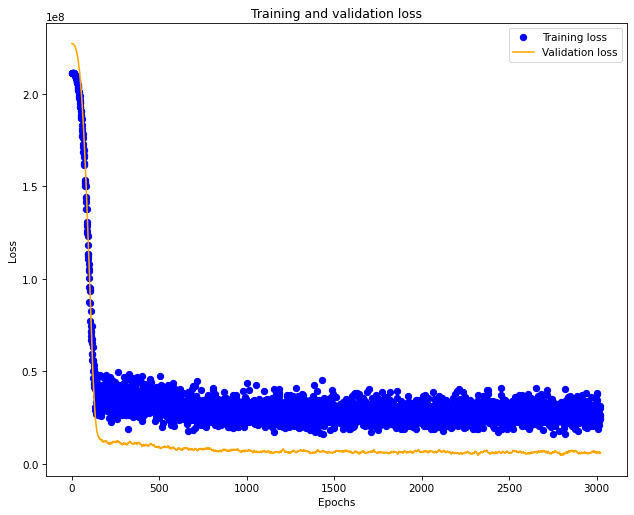

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1) 
plt.figure(figsize=(10, 8), dpi=75)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Actual Vs Predicted

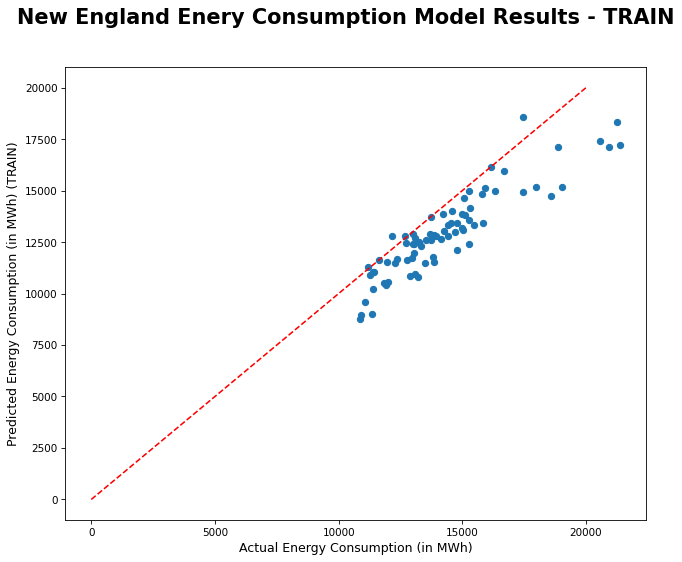

In [ ]:
# Scatterplot for train results
plt.figure(figsize=(10, 8), dpi=75)
plt.scatter(x=y_train, y=train_preds)
plt.plot([0, 20000], [0, 20000], '--k', color='red') # 45 degree line
plt.axis('tight')
plt.xlabel('Actual Energy Consumption (in MWh)', fontsize = 12)
plt.ylabel('Predicted Energy Consumption (in MWh) (TRAIN)', fontsize=12)
plt.suptitle('New England Enery Consumption Model Results - TRAIN', fontsize = 20, fontweight="bold")
plt.show()

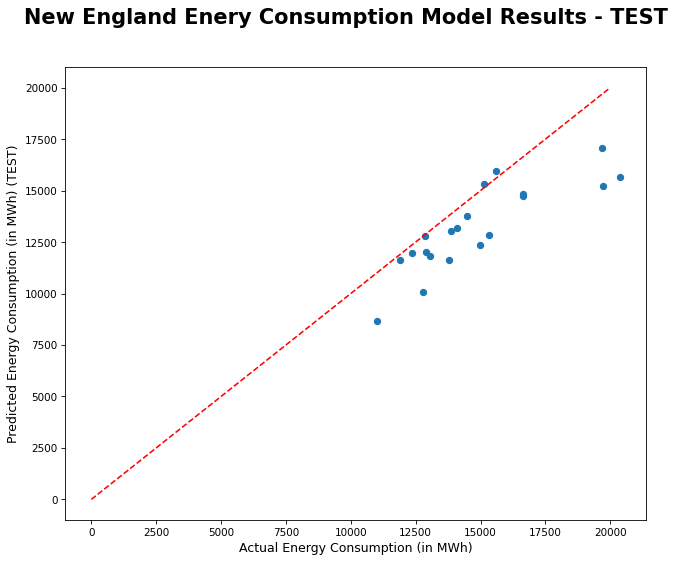

In [ ]:
# Scatterplot for train results
plt.figure(figsize=(10, 8), dpi=75)
plt.scatter(x=y_test, y=test_preds)
plt.plot([0, 20000], [0, 20000], '--k', color='red') # 45 degree line
plt.axis('tight')
plt.xlabel('Actual Energy Consumption (in MWh)', fontsize = 12)
plt.ylabel('Predicted Energy Consumption (in MWh) (TEST)', fontsize=12)
plt.suptitle('New England Enery Consumption Model Results - TEST', fontsize = 20, fontweight="bold")
plt.show()

### Model Metrics

#### R2

In [ ]:
print("This is train R2 (model):", r2_score(y_train, train_preds)) # train
print("This is test R2 (model):", r2_score(y_test, test_preds)) # test

This is train R2 (model): 0.5187986413152856
This is test R2 (model): 0.3119423064479082


#### MAE

In [ ]:
trainMAE_model = mean_absolute_error(y_train, train_preds)
print("This is trainMAE (model):", trainMAE_model) # train
testMAE_model = mean_absolute_error(y_test, test_preds)
print("This is testMAE (model):", testMAE_model) # test

This is trainMAE (model): 1402.7913404605265
This is testMAE (model): 1682.1002265624998


#### RMSE

In [ ]:
rmse = sqrt(mean_squared_error(y_train, train_preds))
print("Root Mean Square Error (train): ", rmse)

Root Mean Square Error (train):  1708.987210133652


In [ ]:
rmse = sqrt(mean_squared_error(y_test, test_preds))
print("Root Mean Square Error (test): ", rmse)

Root Mean Square Error (test):  2130.863097630441


## Insights, Observations and Comments about Model Performance



1.   I tried multiple combinations, and the current version has good model metrics. I built the first model with 4+ hidden layers with early stop having patience=10000, pochs=500000, and batch_size=10. But the model never converged even after running for 50000 epochs. The training loss and validation loss reduced very slowly and were still at around 14300 by the end of the 50000th epoch. I reduced the hidden layers to two with the same values, and the model converged pretty fast. I realized that just increasing the model complexity by increasing the number of hidden layers would not necessarily increase the model's performance.

2.   This is a real-world data. However, more understanding about variables and their functionality is required. For example, sky coverage might cool down temperatures and thus could have an impact on power consumption. But understanding all the variables and their potential impact mandates the possession of domain knowledge.

3. The learning curve plots indicate that both the training loss and validation loss continue to drop as the number of epochs increases. Also, the validation loss almost converged to zero over the epochs compared to training loss. There is consistency in the drop of losses between training and validation, indicating the model is not overfit for training.

4. The plot between actual and predicted indicates that the model is slightly under-predicting the power consumption for most of the data points. R2 score, which is around 51%, implying that model variance cannot be just explained with the considered inputs/parameters. A lot of parameters like sky cover, sea level pressure, atmospheric pressure etc. were not modeled as explained in point 2. However, it is beneficial to slightly over-predict the power consumption in real-world situations to ensure sufficient energy is generated to meet the demand. Feel free to tweak the hyper parameters to get better results.!

